In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
from pmdarima import model_selection
import pickle as pkl

## Initial Data Preprocessing

Let's start by:
* Reading in the data
* Changing the time column into a time stamp
* Reassigning the index

Read in the data

In [2]:
#read in dataset
df = pd.read_csv('Data/AirPassengers.csv')

In [3]:
#get the first n rows of the dataset
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


Change the datatype and index of the dataset

In [4]:
#change the time from string to datetime
df['Month'] = pd.to_datetime(df['Month'])
df.set_index(df['Month'], inplace = True)

## Data Exploration

Let's perform some basic data exploration:
* Time series line plotting
* Our series look multiplicative, but let's decompose it both ways
* Additive decomposition
* Multiplicative decomposition
* Perform an Augmented Dickey Fuller test

Plot the raw series

<AxesSubplot:xlabel='Month'>

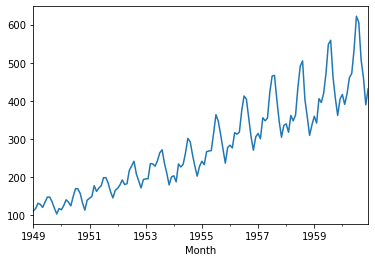

In [5]:
#plot the raw time series
df['#Passengers'].plot()

In both decompositions we see the trends and seasonality very well. We also see some patterns in the residuals

Addititive decomposition

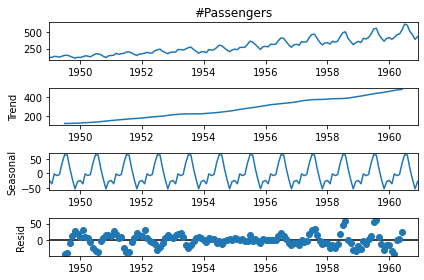

In [6]:
#perform and plot the additive model decompose
result = seasonal_decompose(df['#Passengers'], model='additive')
result.plot()
plt.show()

Multiplicative decomposition

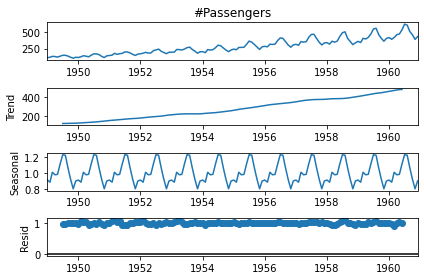

In [7]:
#perform and plot the multiplicative model decompose
result = seasonal_decompose(df['#Passengers'], model='multiplicative')
result.plot()
plt.show()

We perform the adfuller test, and find out it is non-stationary

In [8]:
#run the augmented dickey fuller test
result = adfuller(df['#Passengers'])
print(result)

(0.8153688792060512, 0.991880243437641, 13, 130, {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}, 996.692930839019)


## Seasonal and Non-seasonal Differencing

Now let's difference the series and perform more analysis:
* plot the differenced series
* Retest stationarity

Differentiate the series and plot

<AxesSubplot:xlabel='Month'>

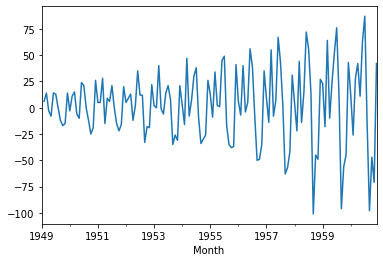

In [9]:
#plot the differenced series
df['diff_series'] = df['#Passengers'].diff()
df['diff_series'].plot()

While not under 0.05, we can say this is good enough to consider the series stationary

In [10]:
#re-run the augmented dickey fuller test
result = adfuller(df['diff_series'].dropna())
print(result)

(-2.829266824169998, 0.054213290283825676, 12, 130, {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}, 988.5069317854084)


Let's perform some seasonality analysis:
* Perform analysis month to month
* Identify the seasonality
* Seasonally difference the raw data and plot
* Seasonally difference the differenced time series and plot

Now let's take a look at our seasonality, we can see the yearly trends

In [11]:
#get the month number
df['month_num'] = [i.month for i in df['Month']]

In [12]:
#group by the month number
yearly_trend = df.groupby('month_num').mean()

<AxesSubplot:xlabel='month_num'>

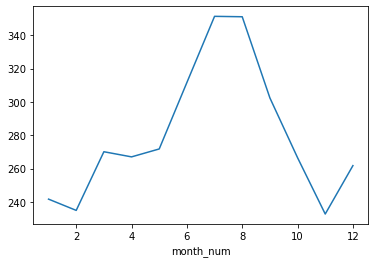

In [13]:
#plot the average value per month number to see seasonality
yearly_trend['#Passengers'].plot()

Since our data was non stationary, we can take a look at the average difference each month, we still see some trends

<AxesSubplot:xlabel='month_num'>

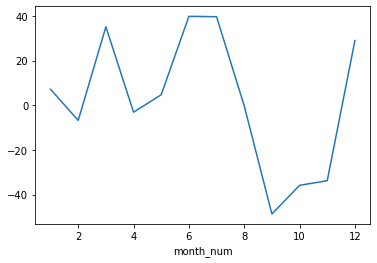

In [14]:
#now let's take a look at the differenced series
yearly_trend['diff_series'].plot()

The raw data seasonal difference shows an interesting trend

In [15]:
#since we see a seasonal trend, we difference based on the season
df['seasonal_raw'] = df['#Passengers'].diff(periods = 12)

<AxesSubplot:xlabel='Month'>

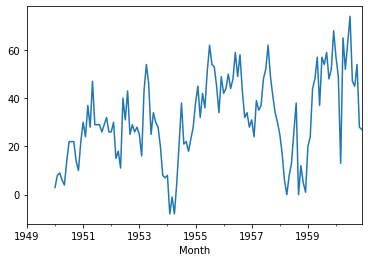

In [16]:
#plot the raw seasonal trend
df['seasonal_raw'].plot()

After seasonally differentiating the differenced set, we can see the trend goes away

In [17]:
#seaosnally difference the differenced series
df['seasonal_diff'] = df['diff_series'].diff(periods = 12)

<AxesSubplot:xlabel='Month'>

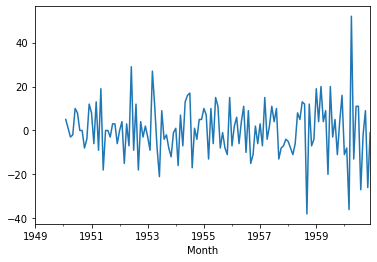

In [18]:
#plot the seasonally difference of teh differenced series
df['seasonal_diff'].plot()

Let's take a look at the acf and pacf plots:
* Look at the acf and pacf plots for the raw data
* Look at the acf and pacf plots for the differenced data

Let's take a look at the raw acf and pacf, though we should make the data stationary, it could be neat to look at this. 
We can see a seasonality peak at 12, and a drop off after 2 lags.

C:\Users\baker\Anaconda3\envs\my-env\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


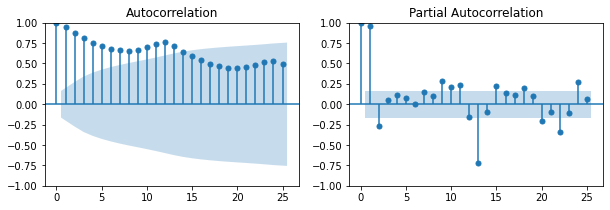

In [19]:
#plot the acf and pacf plots for the raw series
col = '#Passengers'
fig, axes = plt.subplots(1, 2, figsize=(10,3))
# plot autocorrelation
acf = plot_acf(df[col], ax=axes[0],lags=25)
# plot partial autocorrelation
pacf = plot_pacf(df[col], ax=axes[1],lags=25)

Differencing, new trends emerge, we can see the drop-off in auto correlation now. PACF trend is a bit muddled, but we can still try the order conceived.
* let's try the order 2 for AR 1 for I and 1 for MA
* For seasonality, let's try 1 for seasonal AR, 1 for seasonal I, and 0 for seasonal MA

C:\Users\baker\Anaconda3\envs\my-env\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


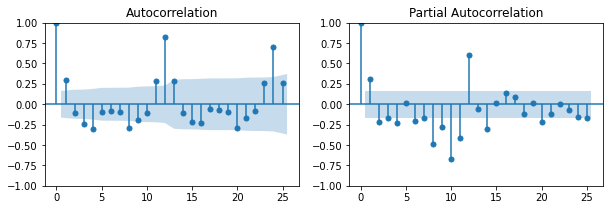

In [20]:
#plot the acf and pacf of the differenced series
fig, axes = plt.subplots(1, 2, figsize=(10,3))
# plot autocorrelation
acf = plot_acf(df['diff_series'].dropna(), ax=axes[0],lags=25)
# plot partial autocorrelation
pacf = plot_pacf(df['diff_series'].dropna(), ax=axes[1],lags=25)

Note: The ACF and PACF plots are not all knowing or even clear, typically they just tell you where to start

## Modeling ARIMA

Let's take the information from the ACF and PACF plots and create the ARIMA plot:
* Split the dataset
* Fit the ARIMA model
* Forecast and assess the accuracy of the forecast
* Visualize the forecasts
* Plot the diagnostics

Let's split the dataset

In [21]:
#establish the proportion
prop = 0.8
#get the series
series = df['#Passengers']
#create a length from the desired proportion
size = int(round(len(series)*prop,0))
#turn the series into a numpy array
passenger_set = series.values
#separate into train and test sets
train, test = passenger_set[0:size], passenger_set[size:len(passenger_set)]

Let's train the ARIMA model using the order derived from the ACF and PACF, we will get into more of the summary later.

In [22]:
#instantiate the arima model
model_ns = ARIMA(train, order=(2,1,1))
#fit the arima model
model_fit_ns = model_ns.fit()
#print the summary
print(model_fit_ns.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  115
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -525.324
Date:                Wed, 22 Mar 2023   AIC                           1058.648
Time:                        12:14:50   BIC                           1069.592
Sample:                             0   HQIC                          1063.089
                                - 115                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0717      0.111      9.615      0.000       0.853       1.290
ar.L2         -0.4397      0.105     -4.177      0.000      -0.646      -0.233
ma.L1         -0.8309      0.110     -7.556      0.0

We will compare this to our other predictions

In [23]:
#forecast the series the same length of the test set
forecasts_ns = model_fit_ns.forecast(len(test))
#compare with the testing set
mean_squared_error(forecasts_ns, test)

6826.245622760094

In [24]:
def forecast_df(forecasts):
    #change to dataframe
    f_df = pd.DataFrame(forecasts)
    #get the proper index
    f_df['index'] = df.index[-len(test):]
    #set the index
    f_df.set_index('index',inplace=True)
    #return the df
    return f_df

In [25]:
#create the forecast df
f_ns = forecast_df(forecasts_ns)

Our forecasts are not looking the best

<AxesSubplot:xlabel='index'>

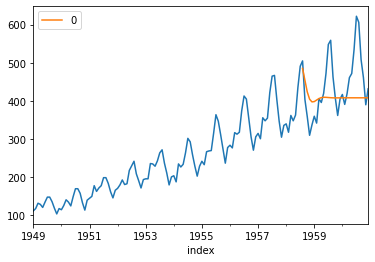

In [26]:
#empty plot
fig,ax = plt.subplots()
#plot the entire series
series.plot(kind='line',ax=ax)
#plot the forecasts
f_ns.plot(kind='line',ax=ax)

Our residual analysis is not looking the best, we see auto correlation, heterostatcity, and some skewness around 0.

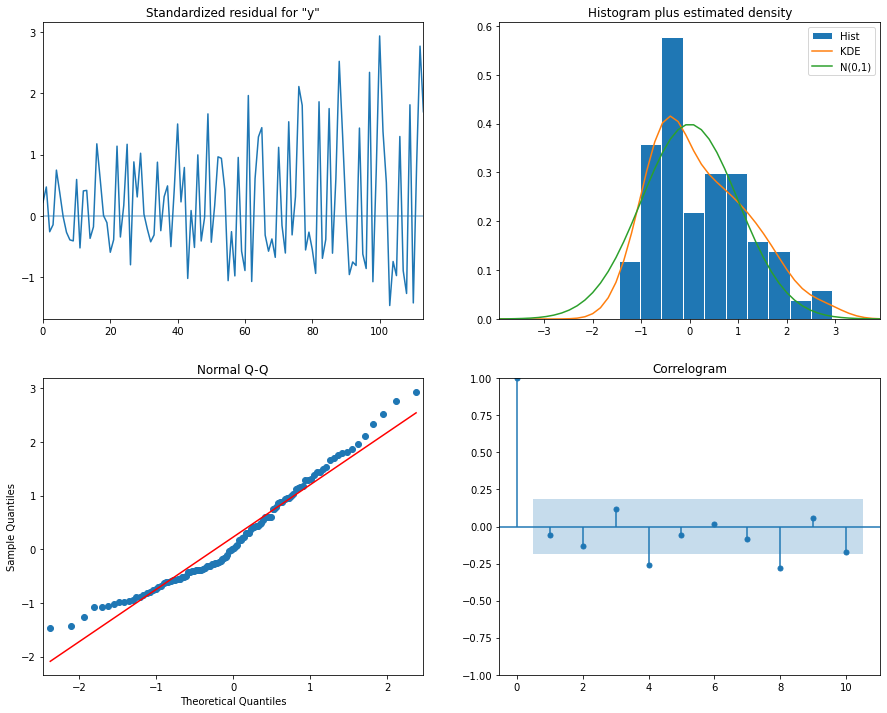

In [27]:
#get the time series diagnostics plot
diag_ns = model_fit_ns.plot_diagnostics(figsize=(15, 12))
plt.show()

## SARIMA Modeling

Let's go back to the ACF and PACf and create our seasonal model:
* Fit the SARIMA model (changed the non seasonal orders to accomodate the model warnings) 
* Forecast the values
* Calculate the errors
* Plot the forecast
* Plot the Diagnostics

Let's fit the SARIMA model, and take a look at some of the statistics

In [28]:
#Instantiate the SARIMAX model
model_s = SARIMAX(train, order=(2,2,2), seasonal_order=(1, 1, 0,12))

#fit the sarima model
model_fit_s = model_s.fit()

#forecast the series the same length of the test set
forecasts_s = model_fit_s.forecast(steps=len(test))

In [29]:
#print the summary
model_fit_s.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  115
Model:             SARIMAX(2, 2, 2)x(1, 1, [], 12)   Log Likelihood                -373.443
Date:                             Wed, 22 Mar 2023   AIC                            758.886
Time:                                     12:14:51   BIC                            774.576
Sample:                                          0   HQIC                           765.238
                                             - 115                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5101      0.760     -0.672      0.502      -1.999       0.979
ar.L2          0.0556      0.204      0.272      0.786      -0.345       0.456
ma.L1         -0.6317      0.897     -0.705      0.481      -2.389       1.126
ma.L2         -0.3640      0.762     -0.478      0.633      -1.857       1.129
ar.S.L12      -0.1262      0.084     -1.499      0.134      -0.291       0.039
sigma2        90.7783     40.246      2.256      0.024      11.898     169.659
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 2.77
Prob(Q):                              0.92   Prob(JB):                         0.25
Heteroskedasticity (H):               1.17   Skew:                             0.36
Prob(H) (two-sided):                  0.65   Kurtosis:                         2.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We can see we have a much lower MSE

In [30]:
#forecast using the sarima model
forecasts_s = model_fit_s.forecast(len(test))
#find the mean squared error to evaluate the model
mean_squared_error(forecasts_s, test)

633.6597706751905

In [31]:
#create the forecast dataset
f_s = forecast_df(forecasts_s)

Our forecasts seem to be immitating the trends far better

<AxesSubplot:xlabel='index'>

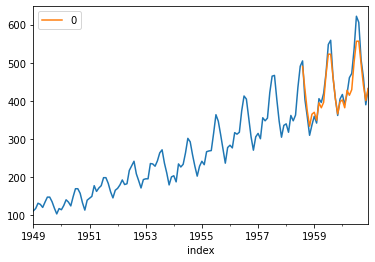

In [32]:
#empty plot
fig,ax = plt.subplots()
#plot the whole time series
series.plot(kind='line',ax=ax)
#plot the seasonality forecasting results
f_s.plot(kind='line',ax=ax)

All of our diagnostic plots look far better, variance seems more consistant, the distribution of residuals seem more normal, and the auto correlation seems insignificant. 

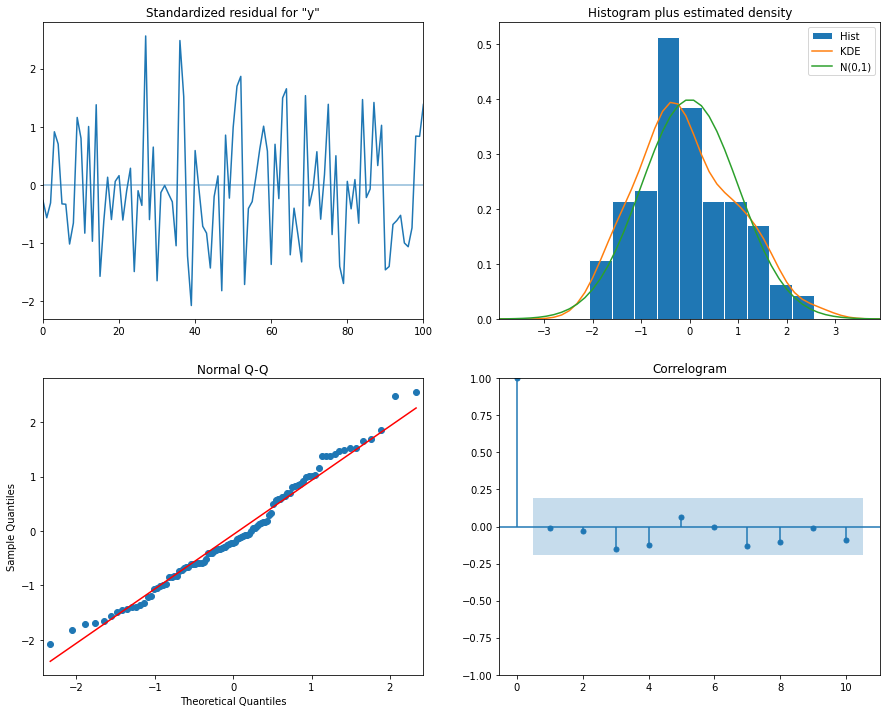

In [33]:
#plot the sarima diagnostic plot
diag_s = model_fit_s.plot_diagnostics(figsize=(15, 12))
plt.show()

## Auto ARIMA and Auto SARIMA

Let's start with a demonstration of the non seasonal auto-arima:
* Fit the auto arima
* Forecast and evaluate the model with MSE
* Plot the forecasts

In [34]:
def forecast_frame(forecasts):
    #convert to the pandas dataframe
    f_df = pd.DataFrame(forecasts)
    #get the index for the forecasts
    f_df.index = df.index[-len(test):]
    #return the dataframe
    return f_df

Let's fit the non seasonal auto arima

In [35]:
#fit the non seasonal auto arima model
auto_arima_ns = pm.auto_arima(train, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=5,
                      seasonal=False)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1059.871, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1076.519, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1069.443, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1064.823, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1076.271, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1057.831, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1061.622, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1060.309, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1071.784, Time=0.03 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1063.715, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1063.084, Time=0.05 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1097.232, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1058.265, Time=0.02 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 0.325 seconds


We notice the MSE has ecreased for non-seasonal

In [36]:
#forecast with the auto arima
forecasts_ns = auto_arima_ns.predict(len(test))
#evaluate
mean_squared_error(forecasts_ns, test)

5845.807350959812

In [37]:
#create the forecasting dataframe
forecasts_ns_df = forecast_frame(forecasts_ns)

We see the trend looks more captured

<AxesSubplot:xlabel='Month'>

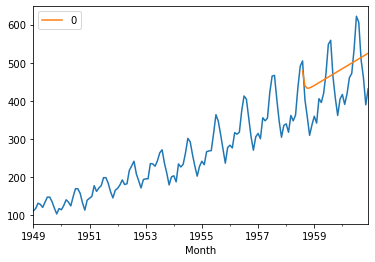

In [38]:
#empty plot
fig,ax = plt.subplots()
#plot the series
series.plot(kind='line',ax=ax)
#plot the forecasts
forecasts_ns_df.plot(kind='line',ax=ax)

Now let's use the seasonal ability of the auto arima:
* Fit the auto arima model
* Forecast the evaluate the model with MSE
* Plot the forecasts

Now let's add in the seaosnality fit, m is the seasonal period

In [39]:
#fit the seasonal auto arima model with default information criterion
auto_arima_s_a = pm.auto_arima(train, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=5,
                      seasonal=True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=760.865, Time=0.10 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=757.826, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=755.752, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=756.382, Time=0.05 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=755.500, Time=0.03 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=755.995, Time=0.05 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=757.915, Time=0.05 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=756.772, Time=0.02 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=756.027, Time=0.02 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=756.012, Time=0.02 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=758.948, Time=0.03 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=757.439, Time=0.02 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12]          
Total fit time: 0.457 seconds


Now we notice the MSE is higher, it should be noted that the parameters will change based on the criterion we want to optimize

In [40]:
#create forecasts
forecasts_s_a = auto_arima_s_a.predict(len(test))
#evaluate
mean_squared_error(forecasts_s_a, test)

1229.5132438203243

In [41]:
#create forecast df
forecasts_s_a_df = forecast_frame(forecasts_s_a)

We notice the forecasts don't look as good as the previous SARIMA

<AxesSubplot:xlabel='Month'>

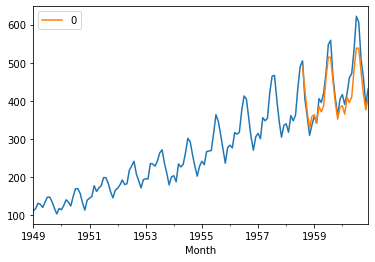

In [42]:
#empty plot
fig,ax = plt.subplots()
#plot the series
series.plot(kind='line',ax=ax)
#plot the forecasts
forecasts_s_a_df.plot(kind='line',ax=ax)

Now let's try a different information criterion for the auto arima:
* Fit the auto arima model
* Forecast the evaluate the model with MSE
* Plot the forecasts

We can see the difference in parameters using BIC instead of AIC

In [43]:
#fit the seasonal auto arima model with bic information criterion
auto_arima_s_b = pm.auto_arima(train, error_action='ignore', trace=True,
                      suppress_warnings=True, information_criterion = 'bic', maxiter=5,
                      seasonal=True, m=12)

Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,1,1)[12]             : BIC=779.240, Time=0.10 sec
 ARIMA(0,1,0)(0,1,0)[12]             : BIC=760.451, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : BIC=763.627, Time=0.03 sec
 ARIMA(0,1,1)(0,1,1)[12]             : BIC=764.257, Time=0.05 sec
 ARIMA(0,1,0)(1,1,0)[12]             : BIC=762.221, Time=0.03 sec
 ARIMA(0,1,0)(0,1,1)[12]             : BIC=762.289, Time=0.04 sec
 ARIMA(0,1,0)(1,1,1)[12]             : BIC=766.903, Time=0.05 sec
 ARIMA(1,1,0)(0,1,0)[12]             : BIC=760.750, Time=0.02 sec
 ARIMA(0,1,1)(0,1,0)[12]             : BIC=761.262, Time=0.02 sec
 ARIMA(1,1,1)(0,1,0)[12]             : BIC=763.902, Time=0.03 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : BIC=765.022, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 0.390 seconds


We notice the MSE got better, but still worse than the original

In [44]:
#create forecasts
forecasts_s_b = auto_arima_s_b.predict(len(test))
#evaluate
mean_squared_error(forecasts_s_b, test)

1023.1724137940473

In [45]:
#create forecast df
forecasts_s_b_df = forecast_frame(forecasts_s_b)

We notice the forecasts do look better

<AxesSubplot:xlabel='Month'>

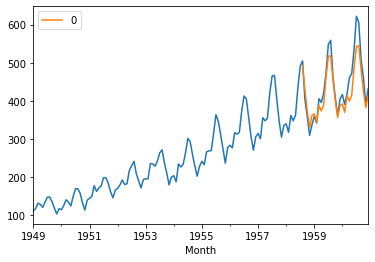

In [46]:
#empty plot
fig,ax = plt.subplots()
#plot the series
series.plot(kind='line',ax=ax)
#plot the forecasts
forecasts_s_b_df.plot(kind='line',ax=ax)

Now let's retrain and save the model

In [47]:
#train the full SARIMA model
model_full = SARIMAX(passenger_set, order=(2,2,2), seasonal_order=(1, 1, 0,12))

#fit the model to all the data
model_fit_full = model_full.fit()

In [48]:
#save the model
model_file = open("Model/time_series_model.pkl", "wb")
pkl.dump(model_fit_full, model_file)
model_file.close()